In [30]:
from scipy import misc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy import interpolate
import cv2 as cv
import os

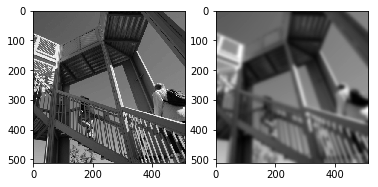

In [2]:
# Example of gaussian filter
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = gaussian_filter(ascent, sigma=5)
ax1.imshow(ascent)
ax2.imshow(result)

In [64]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       source: https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    """
    assert len(image.shape) == 2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

(512, 512)


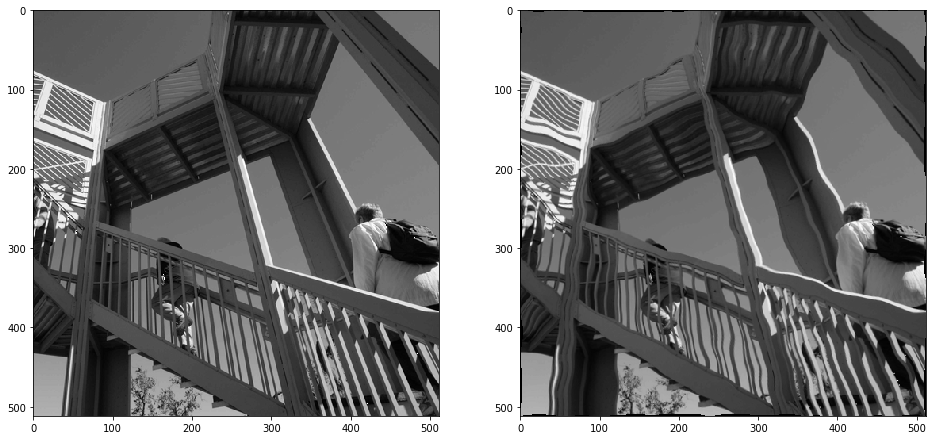

In [4]:
fig = plt.figure(figsize=(16,8))

plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
print(ascent.shape)
result = elastic_transform(ascent,100, sigma=10)
ax1.imshow(ascent)
ax2.imshow(result)

In [5]:
%matplotlib inline
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "./"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")

train_data[:10]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

(785,)


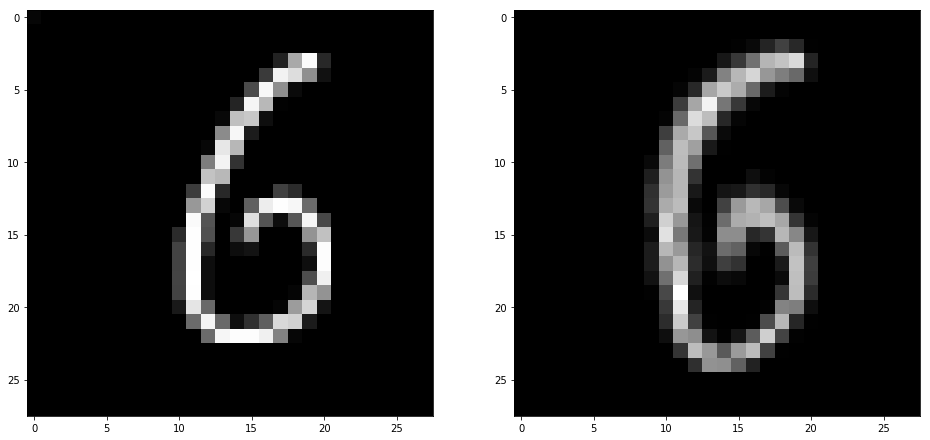

In [6]:
print(train_data[0].shape)
img = np.reshape(train_data[18][:-1],(28,28))
# result = elastic_transform(ascent,1, sigma=1000)

fig = plt.figure(figsize=(16,8))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

result = elastic_transform(img, 34, sigma=5)
ax1.imshow(img)
ax2.imshow(result)

KERNEL SIZE 2 5


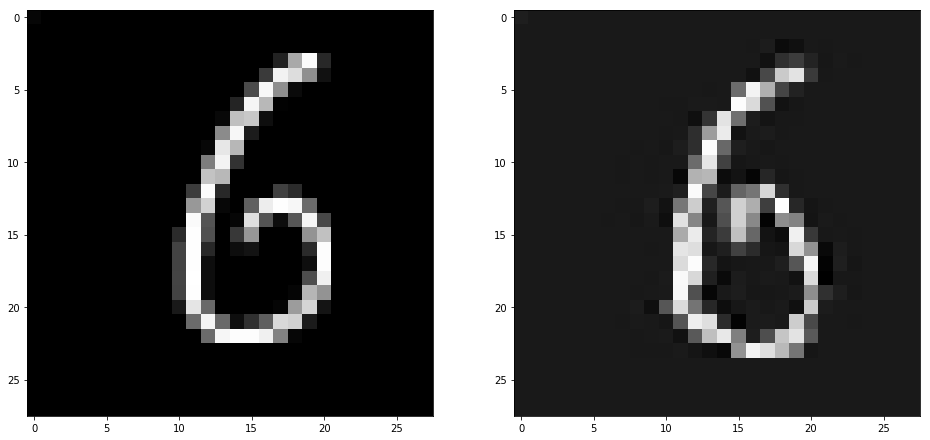

In [29]:
def my_gaussian_filter(x,y, sigma=5):
    return 1/(2*np.pi*sigma**2) * np.exp(-(x**2+y**2) / (2*sigma**2))

def create_kernel(kernel_size=3):
    kernel_center = (kernel_size >> 1) + 1
    kernel = np.zeros((kernel_size, kernel_size))
    for x in range(kernel_size):
        for y in range(kernel_size):
            kernel[x,y] = my_gaussian_filter(x-kernel_center+1,y-kernel_center+1)
    return kernel

def my_elastic_transform(img, alpha, sigma, kernel):
    # generating random displacement field
    dx = alpha*np.random.uniform(low=-1, high=1, size=img.shape)
    dy = alpha*np.random.uniform(low=-1, high=1, size=img.shape)
    
    # convole with standard Gaussian distribution
    new_dx = np.zeros(dx.shape)
    new_dy = np.zeros(dy.shape)
    kernel_size = (len(kernel) >> 1)
    print("KERNEL SIZE", kernel_size, len(kernel))
    for x in range(img.shape[0]-len(kernel)-1):
        for y in range(img.shape[1]-len(kernel)-1):
            new_dx[x+kernel_size, y+kernel_size] = np.sum(np.multiply(dx[x:x+len(kernel), y:y+len(kernel)], kernel))
            new_dy[x+kernel_size, y+kernel_size] = np.sum(np.multiply(dy[x:x+len(kernel), y:y+len(kernel)], kernel)) 
    
    xx, yy = np.meshgrid(img.shape[0], img.shape[1])
    z = img
    f = interpolate.interp2d(range(0,img.shape[0]), range(0,img.shape[1]), z, kind='cubic')
    new_img = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[y, x] = f(x+new_dx[x,y], y+new_dy[x,y])
    return new_img

fig = plt.figure(figsize=(16,8))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

kernel = create_kernel(5)
result = my_elastic_transform(img, 34, sigma=5, kernel=kernel)
ax1.imshow(img)
ax2.imshow(result)


(512, 512)
KERNEL SIZE 30 60


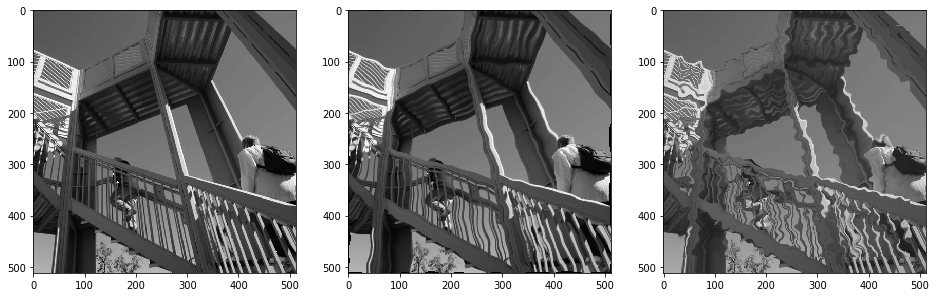

In [33]:
fig = plt.figure(figsize=(16,8))

plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(131)  
ax2 = fig.add_subplot(132)  
ax3 = fig.add_subplot(133)
ascent = misc.ascent()
print(ascent.shape)
result = elastic_transform(ascent, 100, sigma=10)
kernel = create_kernel(60)
my_result = my_elastic_transform(ascent, 100, sigma=10, kernel=kernel)
ax1.imshow(ascent)
ax2.imshow(result)
ax3.imshow(my_result)


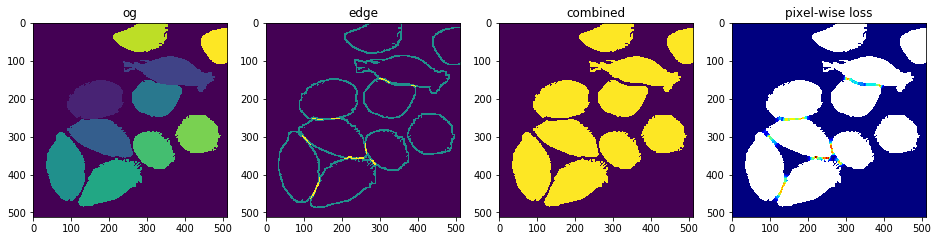

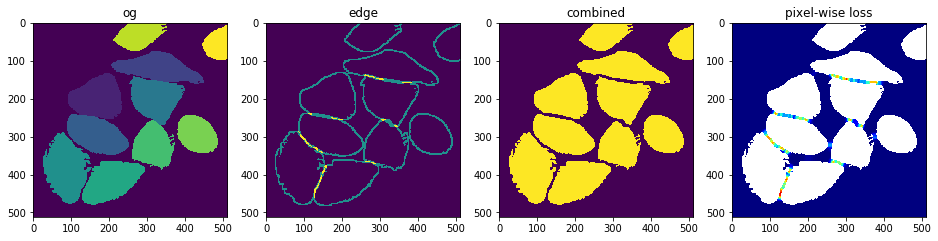

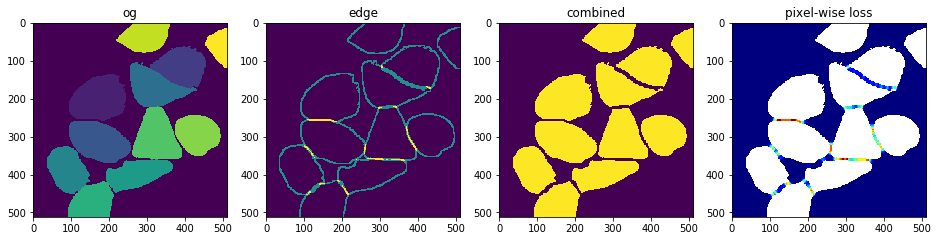

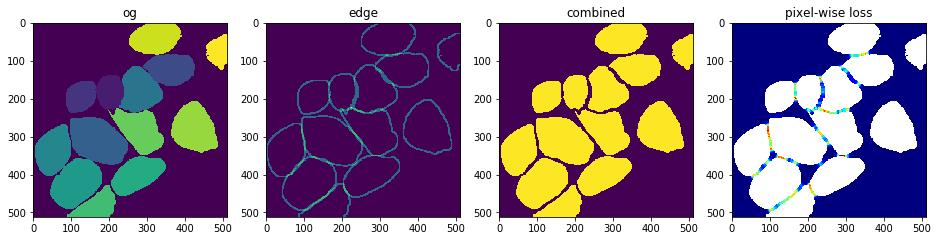

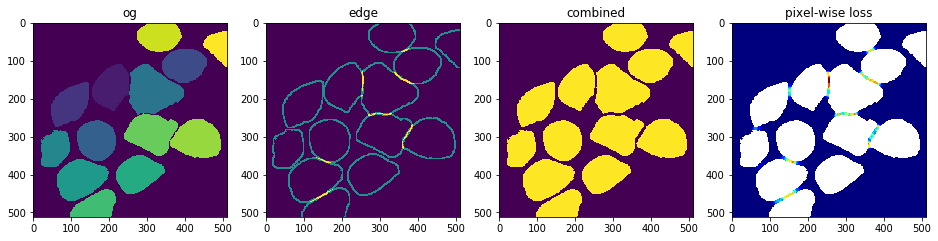

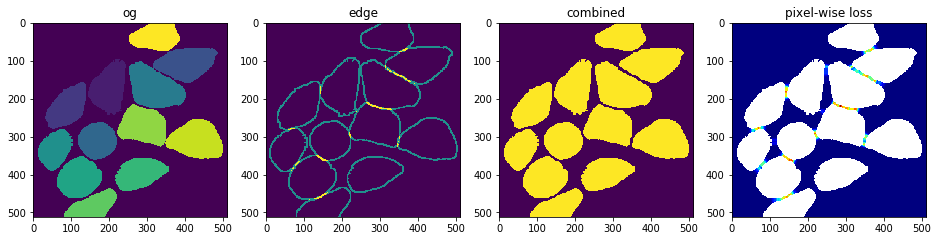

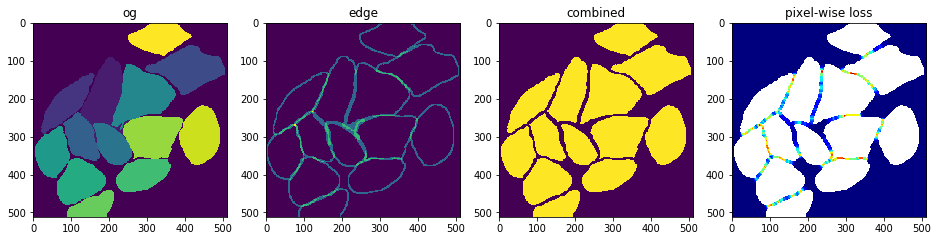

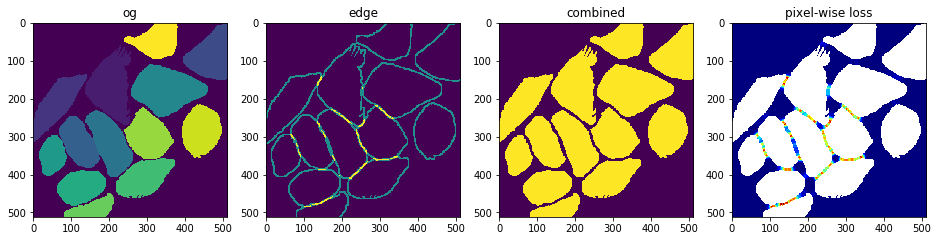

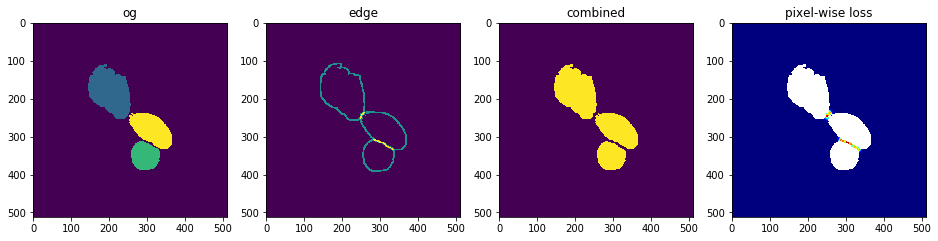

In [67]:
cur_dir = os.path.abspath('')
# DATASET = 'PhC-C2DH-U373'
DATASET = 'DIC-C2DH-HeLa'
target_path = os.path.join(cur_dir, "data", f"{DATASET}-training", "01_GT", "SEG")
target = os.listdir(target_path)
for i in range(len(target)):
    img = cv.imread(os.path.join(target_path, target[i]), -1)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
    kernel2 = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
    mask = np.zeros(img.shape)
    for cls in np.unique(img):
        if cls == 0:
            continue
        thresh = np.zeros(img.shape)
        thresh[img==cls] = 255
        dilated = cv.dilate(thresh,kernel, iterations=2)
        mask += dilated-thresh
#         mask += cv.erode(dilated-thresh,kernel2,iterations=1) 
#         mask +=  cv.morphologyEx(dilated-thresh, cv.MORPH_OPEN, kernel)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('og')
    plt.subplot(1,4,2)
    plt.title('edge')
    plt.imshow(mask)
    plt.subplot(1,4,3)
    combined = img - mask
    combined[combined<0] = 0  # clipping
    ret, combined_bin = cv.threshold(combined, 0, 255, cv.THRESH_BINARY)
    plt.imshow(combined_bin)
    plt.title('combined')

    wc = np.zeros(img.shape)
    for cls in np.unique(img):
        s = np.sum(img==cls)
        wc[combined==cls] = 1/s
    wc = wc / np.max(wc)
    
    w0 = 10
    sigma = 5
    d1 = img.shape[0]*img.shape[1]*np.ones(img.shape)
    d2 = np.zeros(img.shape)

    dsts = []
    for cls in np.unique(img)[1:]:
        b = combined!=cls
        a = combined!=0
        c = a & b
        new_bin = np.zeros(img.shape)
        new_bin[c] = 255
        combined_bin = 255-new_bin.astype(np.uint8)
        dst = cv.distanceTransform(src=combined_bin, distanceType=cv.DIST_L2, maskSize=3)
        d1 = np.minimum(d1, dst)
        d2 = np.maximum(d2, dst)
    
    loss_img = wc + w0*np.exp(-(d1+d2)**2 / (2*sigma**2))
    loss_img[combined > 0] = np.nan
    
    plt.subplot(1,4,4)
    plt.imshow(loss_img, cmap='jet')
    
#     plt.colorbar()
    plt.title("pixel-wise loss")
    plt.show()
    


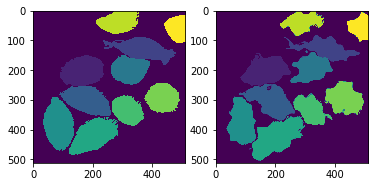

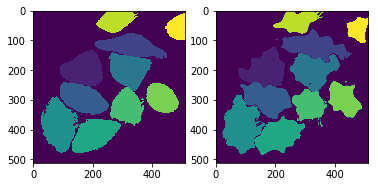

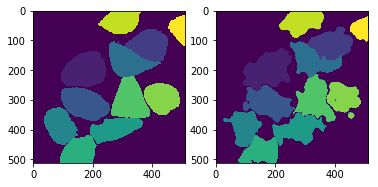

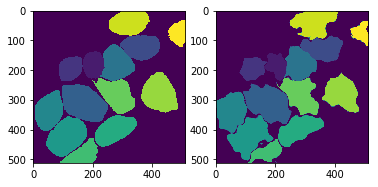

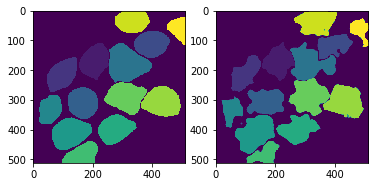

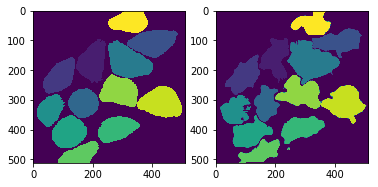

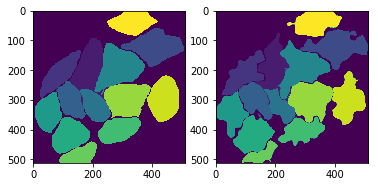

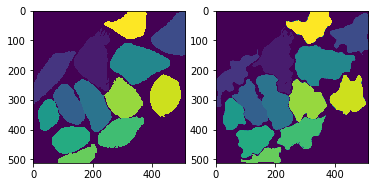

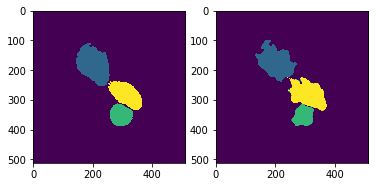

In [72]:
cur_dir = os.path.abspath('')
DATASET = 'PhC-C2DH-U373'
DATASET = 'DIC-C2DH-HeLa'
target_path = os.path.join(cur_dir, "data", f"{DATASET}-training", "01_GT", "SEG")
target = os.listdir(target_path)
for i in range(len(target)):
    img = cv.imread(os.path.join(target_path, target[i]), -1)
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(elastic_transform(img, 500, 10))
    plt.show()